[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.12256949],
       [0.12224426],
       [0.12903061],
       ...,
       [0.76521772],
       [0.75404546],
       [0.77007934]])

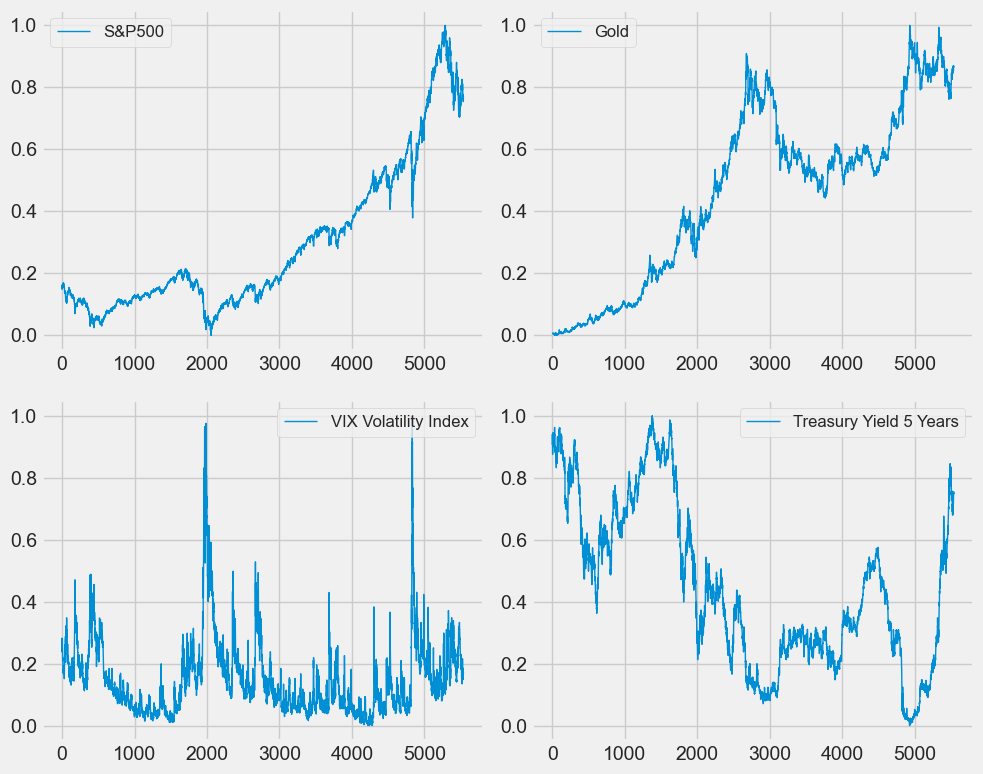

In [1]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 128
output_length = 1
output_steps_ahead = 1
database = dataclass.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.8)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


c:\Users\mihao\Anaconda3\envs\evolver\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(4431, 4)
(1108, 4)
torch.Size([128, 4])
torch.Size([1])
torch.Size([128, 4])


In [3]:
batch_size = 257
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, 1, drop_last = False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [4]:
import torch
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, z, mu, akt):
        n = z.shape[0]
        d = z.shape[2]
        k = mu.shape[0]

        z = z.repeat(1,k,1)

        mu = mu.reshape(1,k,d)
        mu = mu.repeat(n,1,1)

        dist = (z-mu).norm(2,dim=2).reshape((n,k))
        loss = dist.min(dim=1)[0].mean()
        #akt = akt.reshape((n,k))
        #loss = torch.mul(akt, dist).mean()
        return loss
    
class LocalityPreservingLoss(torch.nn.Module):
    def __init__(self):
        super(LocalityPreservingLoss,self).__init__()
    
    def forward(self, x, z):
         
        loss = 0
        return loss
        

In [5]:
def create_cluster_prototype(psi):
    p_num = torch.div(torch.pow(psi,2), torch.sum(psi, 0))
    p_den = torch.sum(torch.div(torch.pow(psi,2), torch.sum(psi, 0)),-1).reshape(-1,1,1)
    return torch.div(p_num,p_den)
        

In [6]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 2*torch.rand(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(torch.rand(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	torch.diag_embed(10*torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        self.msa = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        #self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.fc_con = nn.Linear(input_length, self.num_clusters) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        self.fc_emb = nn.Linear(input_length, 3*self.embed_dim) #output_length
        self.input_layer_norm = nn.LayerNorm(input_length)
        self.ant_norm = nn.LayerNorm(self.cluster_dim)
        #self.evol_drop_layer = nn.Dropout(p=0.5)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size, 1, input_length)
        
        #x = self.input_layer_norm(x)
        self.x_emb = self.fc_emb(x)
        query, key, value = self.x_emb.chunk(3, dim=-1)
        self.x_att, _ = self.msa(query,key,x)
        self.x_att = self.input_layer_norm(self.x_att)
        #self.x_att = x
        
        self.x_ant = self.fc_ant(self.x_att)
        #self.x_ant  = self.ant_norm(self.x_ant)
        #self.x_ant = self.ant_norm(self.x_ant)
        
        x_con = x
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub((self.mu), self.x_ant)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul((self.sigma_inv), torch.transpose((self.sigma_inv), 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        #d2 = torch.matmul(d2_dS, dr)
        self.d2 = torch.matmul(dl, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2))
        self.psi = self.sm(-self.d2).reshape(batch_size, 1, self.num_clusters)
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        #x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con) #.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(self.psi , torch.transpose(y_con,-1,-2))
        
        #final_out = self.fc(out)
        return y

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.lstm_2 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        z, h_en = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        return z, h_en 
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, z, h_en):
        y_lstm, h_de = self.lstm(z, h_en)
        y = self.fc(y_lstm)     
        
        return y, h_de

In [8]:
class Lstm_model(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.encoder = Encoder(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = Decoder(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolving = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads)

    def forward(self, x, h_en, h_de):
        
        z_en, h_en = self.encoder(x, h_en)
        
        z_en = self.fc(z_en)
        
        x_de, h_en = self.decoder(x, h_de)
        y = self.evolving(z_en, x[-1,:,0])
        
        return y, h_en, z_en, x_de

    def init(self):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
                
embed_dim = input_length
num_heads = 11
cluster_dim = 2
num_clusters = 3
input_dim = 4
output_dim = 1
hidden_size = 7
num_layers = 1
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)



AssertionError: embed_dim must be divisible by num_heads

In [ ]:
def plot_ellipse(sigma_inv, mu, z):
    display.clear_output(wait=True) 
    sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
    sigma = inv(sigma_inv.detach().cpu().numpy())
    nc_plot = num_clusters
    sigma = sigma[0:nc_plot,0:2,0:2]
    mu = mu[0:nc_plot,0:2]
    ellipse = compute_ellipse.Ellipse(sigma,mu,1)
    ellipse_points = ellipse.confidence_ellipse()
    ellipse_points = np.einsum('ijk->jik', ellipse_points)
    plt.plot(z[:,0,0],z[:,0,1],'.k')
    plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
    plt.show()  
    display.display(pl.gcf())   

In [ ]:
def train(dataloader,train):
    h_en, h_dn = model.init()
    model.train()
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        y_hat, h_en, z_en, x_de = model(x.reshape(input_length, batch_size, input_dim), h_en)

        #Cluster prototype shape
        P = create_cluster_prototype(model.evolve.psi)
        
        loss_y = loss_fun_y(y_hat.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_x = loss_fun_x(x, y.reshape(batch_size, output_dim,-1))
        loss_clust = loss_fun_clust(model.evolve.x_ant,model.evolve.mu, model.evolve.psi)
        loss_shape = loss_fun_shape(P, model.evolve.psi)
        
        #loss_local = loss_fun_local(x, model.evolve.x_ant)
        if train == "encoder":
            loss = loss_recon
        elif train == "clusters":
            loss = loss_clust + loss_assign
        elif train == "output":
            loss = loss_con

        loss = loss_y + loss_x + loss_shape + loss_clust
        #loss = (1-alpha)*loss_con + alpha*(loss_ant)
        # loss_b = 0.1
        # loss_a = 0.5
        #loss = alpha*(loss_y) + (1-alpha)*(loss_b*loss_shape + (1-loss_b)*loss_clust)
        loss_sum = loss_sum + loss.item()
        
        x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant

SyntaxError: invalid syntax (332496603.py, line 20)

model.evolve.mu.grad
model.evolve.sigma_inv.grad
model.evolve.msa.in_proj_weight.grad
model.evolve.msa.in_proj_bias.grad
model.evolve.msa.out_proj.weight.grad
model.evolve.msa.out_proj.bias.grad
model.evolve.fc_ant.weight.grad
model.evolve.fc_ant.bias.grad
model.evolve.fc_con.weight.grad
model.evolve.fc_con.bias.grad
model.evolve.fc_emb.weight.grad
model.evolve.fc_emb.bias.grad
model.evolve.input_layer_norm.weight.grad
model.evolve.input_layer_norm.bias.grad
model.evolve.ant_norm.weight.grad
model.evolve.ant_norm.bias.grad

In [ ]:
def test(dataloader):
    h_en = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        y_hat, h_en, z_en, x_de = model(x.reshape(input_length, batch_size, input_dim), h_en)
        loss = loss_fun_y(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-0.0999,  0.2960,  0.1304, -0.3204],
        [ 0.3347, -0.2529,  0.2867, -0.1796],
        [-0.1257, -0.0977,  0.0302, -0.1897],
        [ 0.2646,  0.2405, -0.3193,  0.0015],
        [-0.3357, -0.0787, -0.1900, -0.3503],
        [-0.1410, -0.0695, -0.2890,  0.2992],
        [ 0.1697, -0.3185, -0.3501, -0.2724],
        [-0.2059, -0.3028, -0.1756, -0.3488],
        [ 0.2426, -0.3058,  0.0226, -0.1193],
        [-0.2113,  0.0591,  0.1062,  0.2056],
        [-0.1602, -0.0708, -0.1550, -0.2227],
        [-0.2569, -0.1287,  0.3370,  0.1291],
        [-0.1251, -0.2709,  0.3289, -0.0621],
        [-0.0713,  0.1927, -0.1179,  0.3411],
        [ 0.3466,  0.1444, -0.1188, -0.2594],
        [-0.2501, -0.2736,  0.3379, -0.0158],
        [-0.0279, -0.1347,  0.1983, -0.2430],
        [-0.3520, -0.0157,  0.0451,  0.0826],
        [-0.2498, -0.2857, -0.3209,  0.3517],
        [ 0.0800,  0.2836,  0.0532,  0.1166],
        [-0.2545, -0.2215,  0.0826, -0.3291],
        [ 0.3059

In [ ]:

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

batch_size = 257
best_model = 1
loss_fun_x = nn.MSELoss() #Encoder-decoder loss
loss_fun_y = nn.MSELoss() #Output loss
loss_fun_shape = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="batchmean", log_target=False) #Similar clusters
loss_fun_clust = KMeansClusteringLoss() #Clusters on features
#loss_fun_local = LocalityPreservingLoss() #inputs -> features locality
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")

lr = 1e-3
for p in model.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
train_iterations = 50
epochs = 10
for i in range(train_iterations):
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader,train)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve_cluster_encoder.pt")  

        if True:
            plot_ellipse(model.evolve.sigma_inv, model.evolve.mu, x_ant_train)


NameError: name 'nn' is not defined

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:
from torchsummary import summary

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])

model.load_state_dict(torch.load("model_evolve_cluster_encoder.pt"))
model.eval()


Parameter containing:
tensor([-0.0519, -0.0409,  0.0788], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 5.9129e-02,  3.4821e-02,  6.1588e-03,  6.7250e-02, -3.5225e-02,
          5.8687e-02, -1.2385e-02,  1.4543e-02,  9.0783e-02,  1.2623e-02,
         -3.2536e-02, -4.6449e-02,  7.3737e-02,  5.3600e-03,  5.1441e-03,
         -6.4456e-03, -2.8386e-02,  1.0136e-01,  4.0979e-03, -7.1014e-02,
         -5.3766e-02, -5.1713e-02,  5.6278e-03, -3.0739e-02,  4.4004e-02,
          1.0135e-01, -5.2752e-02,  4.7577e-02,  4.2894e-02, -4.5480e-02,
          4.3005e-02,  3.8120e-02, -4.8864e-02,  1.2099e-02,  4.1177e-02,
          4.7352e-02,  5.0232e-02,  6.0846e-02,  2.8641e-02,  8.3863e-02,
          4.9759e-02,  3.7511e-02, -5.1695e-02, -1.6566e-02, -4.5886e-02,
          7.0491e-02, -5.9353e-02, -4.7399e-02,  5.1497e-02, -7.1518e-03,
         -3.5715e-02, -1.8250e-02,  9.7449e-02,  5.0345e-02,  1.9975e-02,
          1.0211e-01, -1.7939e-02, -5.2753e-02, -3.7015e-04,  3.8347e

Lstm_model(
  (lstm): LSTM(4, 8)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (evolve): EvolvingSystem(
    (msa): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc_ant): Linear(in_features=128, out_features=2, bias=True)
    (fc_con): Linear(in_features=128, out_features=3, bias=True)
    (sm): Softmax(dim=1)
    (fc_emb): Linear(in_features=128, out_features=384, bias=True)
    (input_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (ant_norm): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  )
)

In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [ ]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    with torch.no_grad():
        h_en, h_de = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, 1, input_dim), h_en, h_de)
            pred = pred.detach().cpu().numpy().reshape(1,-1)
            y = y.detach().cpu().numpy()
            pred_arr = pred_arr + list(pred[0,-1].reshape(-1))
            y_arr = y_arr + list(y[0,-1].reshape(-1))
            x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
    return pred_arr, y_arr, x_ant
    
batch_size = 1
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



NameError: name 'whole_y_arr' is not defined

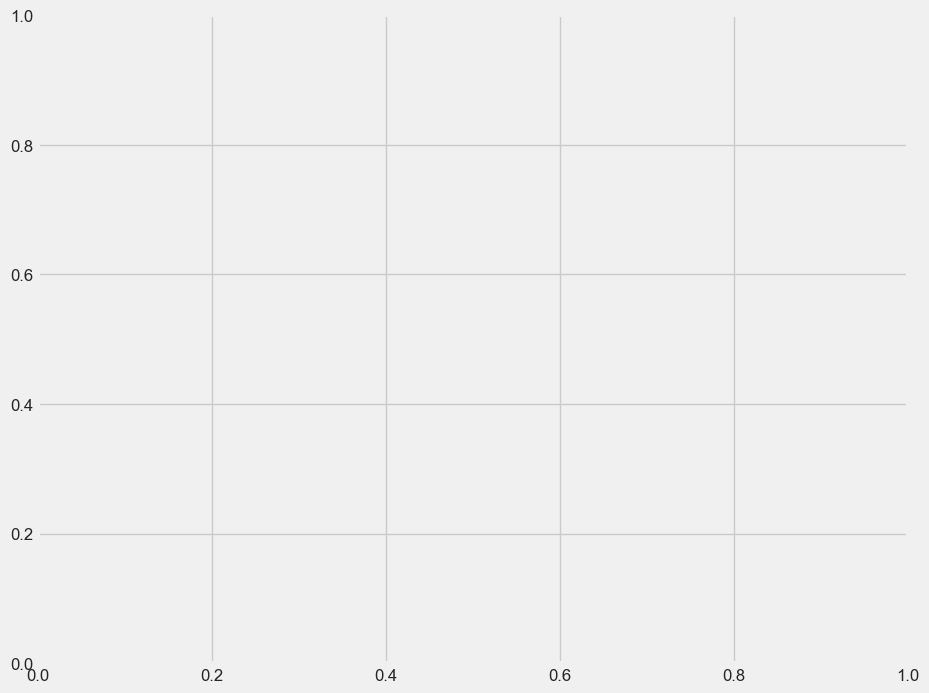

In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (10, 8))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve_cluster_encoder.pdf")

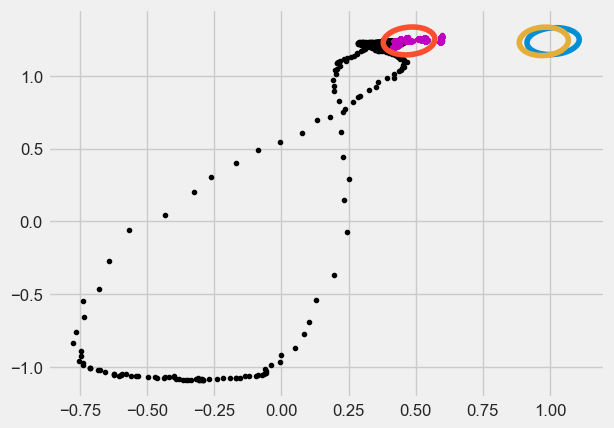

In [ ]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv

sigma_inv = model.evolve.sigma_inv
mu = model.evolve.mu.detach().cpu().numpy()
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())
nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = mu[0:nc_plot,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  


In [ ]:
history -g


 1/1: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 1/2: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 2/1: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 3/1: !python tools/test.py con

In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''

"\n%matplotlib inline\nimport time\nimport pylab as pl\nfrom IPython import display\n#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)\n#line1, = axes2.plot(np.zeros(output_length))\n#line2, = axes2.plot(np.zeros(output_length))\n\nimport matplotlib.pyplot as plt\nimport time\n\ndef simulate(dataloader):\n    pred_arr = []\n    y_arr = []\n    with torch.no_grad():\n        hn, cn = model.init()\n        for batch, item in enumerate(dataloader):\n            x, y = item\n            x, y = x.to(device), y.to(device)\n            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]\n            pred = pred.detach().cpu().numpy().reshape(-1,1)\n            #pred = pred.view(1, output_length)\n            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)\n            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)\n            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)\n            #y = scalar.inverse